# SIS Model with no demographics

Moving on from the SI model to something slighlty more complex, we will add a state transition from infected back to susceptible, with no period of immunity - this is the SIS model.  It turns out that the equations governing this will be analogous to the SI model with demography - rather than births & mortality providing routes to add susceptibles and subtract infectives, this transition from infective -> susceptible will provide essentially the same mechanism. 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \gamma I\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I
$$

As before, subbing $S = N-I$ into the second equation gives us

$$ \dot{I} = \beta I ( 1-\frac{\gamma}{\beta}-\frac{I}{N})$$

And comparing against the SI model with births, it is clear this equation is of the same form, with solution
$$
\frac{Nx}{1+(\frac{Nx}{I_0}-1)e^{-\beta x t}} \\
x = (1-\frac{\gamma}{\beta})
$$


This notebook tests the implementation and behavior of the model as follows:
### Contruct the model
In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with three components: `Susceptibility`, `Transmission`, and `Infection_SIS` - this component will require a new agent property `itimer`, and upon expiration of `itimer` agents will return to the susceptible state.  Finally, we initialize with a single infection and run.  The `Susceptibility` and `Transmission` components are previously described. 


### Sanity check
The first test ensures certain basic constraints are being obeyed by the model.  We confirm that at each timestep, $S_t=N_t-I_t$. 

### Scientific test
Finally, we come to the scientific test.  As before, we first test on a single instance of the model and show that the expected output is recovered.  Then, we select a few values of $\beta$ and $\gamma$, run the model, fit the outputs to the logistic equation, and compare the fitted value of $\beta$ and $\gamma$ to the known values; all of the considerations noted in the SI with births model, in terms of how to approach this fit, are echoed again here.  Of particular concern is the approximation of an exponential transition from infected back to susceptible - as we are doing a first-order finite timestep integration here, that approximation will probably produce an error linear in $\gamma \Delta t$ between the analytic result and the modeled result.  In fact, in a lot of real disease models, we have compartment dwell times in the exposed and infective states that are only a handful of $\Delta t$ long, but when doing real epi modeling and calibrating model parameters to uncertain data, this is generally not likely to be a dominant source of bias, uncertainty, etc.  But when comparing specifically against an analytic result, it can become significant.  



In [14]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import laser.core
import laser.generic

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")


np.__version__='2.2.6'
laser.core.__version__='0.7.0'
laser.generic.__version__='0.0.0'


In [15]:
import laser.core.distributions as dists
import laser.generic.SIS as SIS
from laser.generic import Model
from laser.generic.newutils import grid

To make sure we don't accumulate lots of finite time-step error, make inf mean quite long in units of timestep

In [16]:
pop = 3e5

scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 1
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected
parameters = PropertySet({"seed": 42, "nticks": 3000, "beta": 0.1, "inf_mean": 32})

infdurdist = dists.exponential(scale=parameters.inf_mean)


In [17]:
# Run until we get an outbreak
outbreak = False
while not outbreak:
    parameters.seed += 1
    model = Model(scenario, parameters)

    model.components = [SIS.Susceptible(model), SIS.Infectious(model, infdurdist), SIS.Transmission(model, infdurdist)]

    model.run()
    outbreak = np.any(model.nodes.I[200] > 0)


300,000 agents in 1 node(s): 100%|██████████| 3000/3000 [00:01<00:00, 1957.72it/s]


# Sanity checks
Check that the relationships between susceptible, infected, and total population hold.

### This calculation isn't informative. We should look at S, I, and incidence to check consistency.

S[t] = S[t-1] + recovered[t-1] - incidence[t-1]:  True
I[t] = I[t-1] - recovered[t-1] + incidence[t-1]:  True


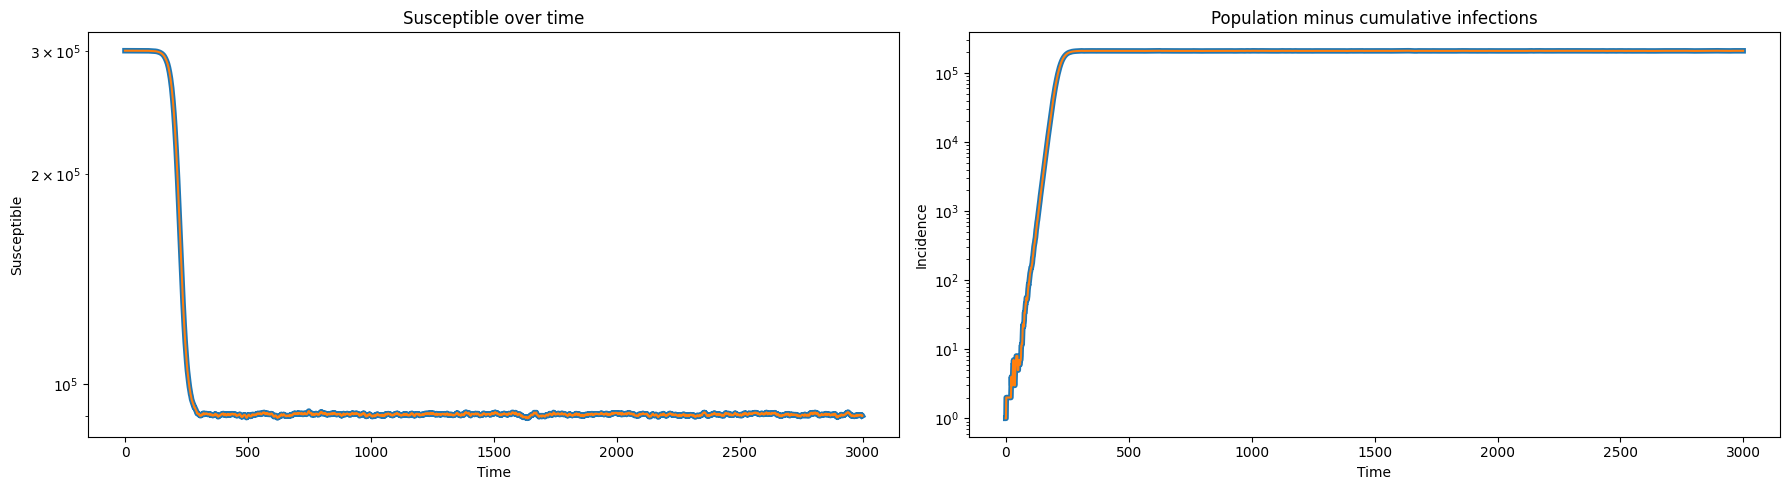

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Panel 2: Susceptible over time
axs[0].plot(model.nodes.S[1:], lw=4)
axs[0].plot(model.nodes.S[:-1] + model.nodes.newly_recovered[:-1] - model.nodes.newly_infected[:-1])
axs[0].set_yscale("log")
axs[0].set_title("Susceptible over time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Susceptible")

# Panel 3: Population minus cumulative infections (incidence)
axs[1].plot(model.nodes.I[1:], lw=4)
axs[1].plot(model.nodes.I[:-1] - model.nodes.newly_recovered[:-1] + model.nodes.newly_infected[:-1])
axs[1].set_yscale("log")
axs[1].set_title("Population minus cumulative infections")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Incidence")

plt.tight_layout()

print("S[t] = S[t-1] + recovered[t-1] - incidence[t-1]: ", np.allclose(model.nodes.S[1:], model.nodes.S[:-1] + model.nodes.newly_recovered[:-1] - model.nodes.newly_infected[:-1]))
print("I[t] = I[t-1] - recovered[t-1] + incidence[t-1]: ", np.allclose(model.nodes.I[1:], model.nodes.I[:-1] - model.nodes.newly_recovered[:-1] + model.nodes.newly_infected[:-1]))


### Single-simulation check
As before, starting with a single infection induces some stochasticity in terms of when the outbreak really starts to take off, and so we fit the expected behavior with a free offset parameter below.

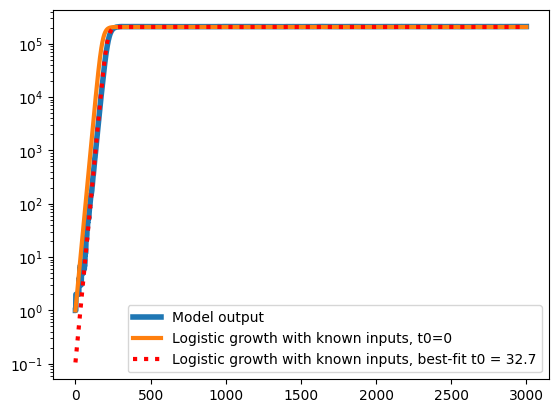

In [19]:
def SIS_logistic(t, beta, popsize, gamma, t0):
    x = 1 - gamma / beta
    return popsize * x / (1 + (popsize * x - 1) * np.exp(-beta * x * (t - t0)))


t = np.arange(model.params.nticks+1)


def objective(t0):
    return np.sum(
        (1 - SIS_logistic(t, model.params.beta, pop, 1 / model.params.inf_mean, t0) / np.squeeze(model.nodes.I)) ** 2
    )


result = minimize(objective, x0=10)
t0_opt = result.x[0]

plt.plot(model.nodes.I, lw=4)
plt.plot(SIS_logistic(t, model.params.beta, pop, 1 / model.params.inf_mean, 0), lw=3)
plt.plot(SIS_logistic(t, model.params.beta, pop, 1 / model.params.inf_mean, t0_opt), "r:", lw=3)
plt.yscale("log")
plt.legend(["Model output", "Logistic growth with known inputs, t0=0", f"Logistic growth with known inputs, best-fit t0 = {t0_opt:.1f}"])

## Scientific testing
Finally, we run the model for a range of $\beta$ & $\gamma$  parameters, we freely fit the model output to the logistic equation, and we compare the known input parameters against the parameters fitted from output.  

We will use only relatively large values of $\gamma$ for this procedure.  The reason why will become clear in a second test, where we demonstrate that there is an error between the expected final size and the modeled final size, and that this error shrinks with $\gamma \Delta t$, as we would expect a first-order approximation error to.  

To make this a pass-fail test, we will raise a flag if the fitted parameters are more than 5% different than the known ones.

In [20]:
# %%capture

NTESTS = 10
nticks = 730
t = np.arange(nticks)
betarange = [0.02, 0.1]
gammarange = [1 / 300, 1 / 100]
seeds = list(range(NTESTS))
pop = 1e5
betas = np.random.uniform(betarange[0], betarange[1], NTESTS)
gammas = np.random.uniform(gammarange[0], gammarange[1], NTESTS)
scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 3
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected

rows = []
for i, (seed, beta, gamma) in enumerate(zip(seeds, betas, gammas)):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta, "inf_mean": 1 / gamma})

    model = Model(scenario, parameters)

    infdurdist = dists.exponential(scale=parameters.inf_mean)

    model.components = [SIS.Susceptible(model), SIS.Infectious(model, infdurdist), SIS.Transmission(model, infdurdist)]

    model.run(label=f"SIS {i+1:2} of {NTESTS}, seed={seed}, beta={beta:.3f}, gamma={gamma:.5f}")
    cases = model.nodes.I[1:,0]
    popt, pcov = curve_fit(
        SIS_logistic,
        t,
        cases,
        p0=[np.mean(betarange), pop, np.mean(gammarange), 1],
        bounds=([betarange[0] / 2, pop - 1, gammarange[0] / 2, -300], [betarange[1] * 2, pop + 1, gammarange[1] * 2, 300]),
    )

    rows.append(
        {
            "seed": seed,
            "beta": beta,
            "gamma": gamma,
            "cases": [np.array(cases)],
            "fitted_beta": popt[0],
            "fitted_gamma": popt[2],
            "fitted_t0": popt[3],
            "recovered": [np.array(model.nodes.newly_recovered[1:,0])]
        }
    )

output = pd.DataFrame(rows)


SIS 10 of 10, seed=9, beta=0.043, gamma=0.00433: 100%|██████████| 730/730 [00:00<00:00, 1947.81it/s]


(-0.25, 0.25)

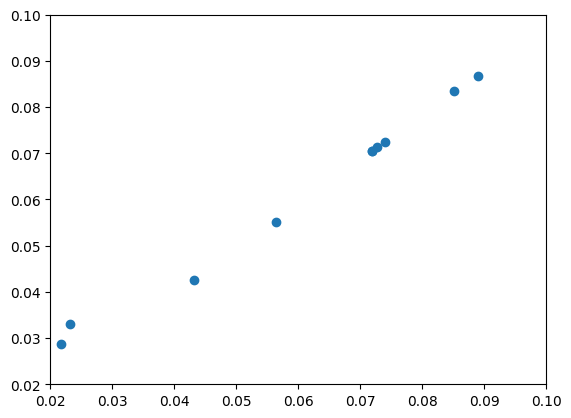

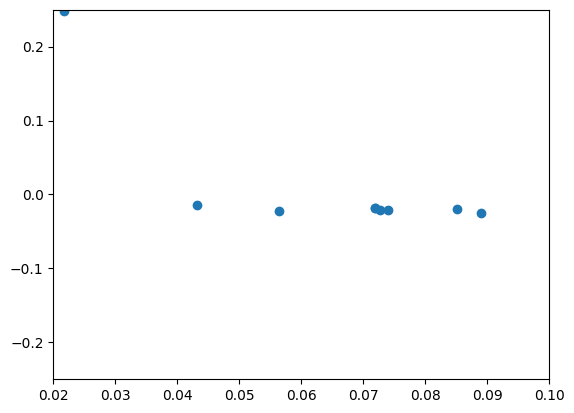

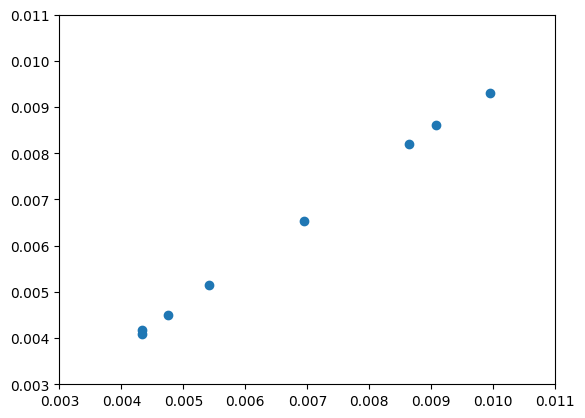

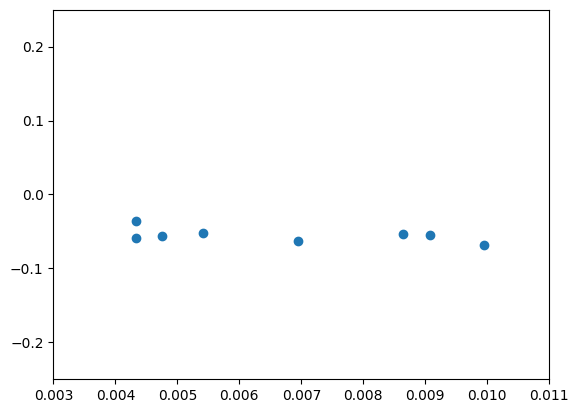

In [21]:
plt.figure()
plt.plot(output["beta"], output["fitted_beta"], "o")
plt.xlim(betarange[0], betarange[1])
plt.ylim(betarange[0], betarange[1])
plt.figure()
plt.plot(output["beta"], 1 - output["beta"] / output["fitted_beta"], "o")
plt.xlim(betarange[0], betarange[1])
plt.ylim(-0.25, 0.25)
plt.figure()
plt.plot(output["gamma"], output["fitted_gamma"], "o")
plt.xlim(gammarange[0]*0.9, gammarange[1]*1.1)
plt.ylim(gammarange[0]*0.9, gammarange[1]*1.1)
plt.figure()
plt.plot(output["gamma"], 1 - output["gamma"] / output["fitted_gamma"], "o")
plt.xlim(gammarange[0]*0.9, gammarange[1]*1.1)
plt.ylim(-0.25, 0.25)

In [22]:
print(
    "All fitted beta are within 10% of known beta: " + str(np.all(np.abs((output["beta"] - output["fitted_beta"]) / output["beta"]) < 0.10))
)
print(
    "All fitted gamma are within 20% of known gamma: "
    + str(np.all(np.abs((output["gamma"] - output["fitted_gamma"]) / output["gamma"]) < 0.20))
)

All fitted beta are within 10% of known beta: False
All fitted gamma are within 20% of known gamma: False


In [23]:
output

,seed,beta,gamma,cases,fitted_beta,fitted_gamma,fitted_t0,recovered
0,0,0.072710,0.008639,"[[3, 3, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, ...",0.071252,0.008195,-29.847682,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
1,1,0.073910,0.009073,"[[3, 3, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, ...",0.072436,0.008606,-31.250384,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
2,2,0.085150,0.006943,"[[4, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 22...",0.083488,0.006530,-25.756218,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
3,3,0.088931,0.009944,"[[4, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 22...",0.086775,0.009313,-25.841016,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
4,4,0.056382,0.005413,"[[3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 6, 5, 5,...",0.055176,0.005148,-14.014934,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
5,5,0.021649,0.008941,"[[3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,...",0.028780,0.016113,14.060801,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,6,0.071903,0.004341,"[[3, 3, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, ...",0.070600,0.004099,-28.864728,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
7,7,0.071889,0.004758,"[[3, 3, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, ...",0.070599,0.004504,-28.979043,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."
8,8,0.023074,0.009794,"[[3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,...",0.033070,0.020000,88.957760,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9,9,0.043157,0.004330,"[[3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 6, 5, 5,...",0.042554,0.004181,-33.457355,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,..."


### Quick demonstration of first-order error accumulation
As noted before, for $\gamma \Delta t$ large, first-order integration like we are doing here can accumulate substantial error.  Calculating exactly how error will accumulate in an integrator for a dynamic process like this is beyond the scope here, and probably depends on a lot of details.  E.g., the ordering of steps - in a given step, does the `transmission` update from S->I state occur before or after the `infection` update that sends agents from I->S?  Do we use midpoint methods, timer countdowns, or take advantage of the unique memorylessness of the exponential distribution to simply remove a random fraction each time?  All that is beyond scope here, but just want to demonstrate that the error in the equilibrium value $I(t \rightarrow \infty)$ becomes large when the mean infectious period $\frac{1}{\gamma}$ is on the same order as $\Delta t$

In [24]:
# %%capture

gammas = [1 / infmean for infmean in [1, 1.5, 2, 2.5, 3, 6, 12, 18, 30, 45, 60, 90, 120, 180, 240, 300]]
betas = [3 * gamma for gamma in gammas]

NTESTS = len(gammas)
nticks = 3000
seeds = list(range(NTESTS))
pop = 1e5
final_expected = np.array([])
final_observed = np.array([])
scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 20
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected

for i, (seed, beta, gamma) in enumerate(zip(seeds, betas, gammas)):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta, "inf_mean": 1 / gamma})

    model = Model(scenario, parameters)

    infdurdist = dists.exponential(scale=parameters.inf_mean)

    model.components = [SIS.Susceptible(model), SIS.Infectious(model, infdurdist), SIS.Transmission(model, infdurdist)]

    model.run(label=f"SIS {i+1:2} of {NTESTS}, seed={seed:2}, beta={beta:.3f}, gamma={gamma:.5f}")
    final_observed = np.append(final_observed, model.nodes.I[-1,0])
    final_expected = np.append(final_expected, pop * (1 - gamma / beta))

SIS 16 of 16, seed=15, beta=0.010, gamma=0.00333: 100%|██████████| 3000/3000 [00:00<00:00, 3077.87it/s]


Text(0.5, 1.0, 'Error in equilibrium infected fraction increases roughly linearly in $\\gamma \\Delta t$')

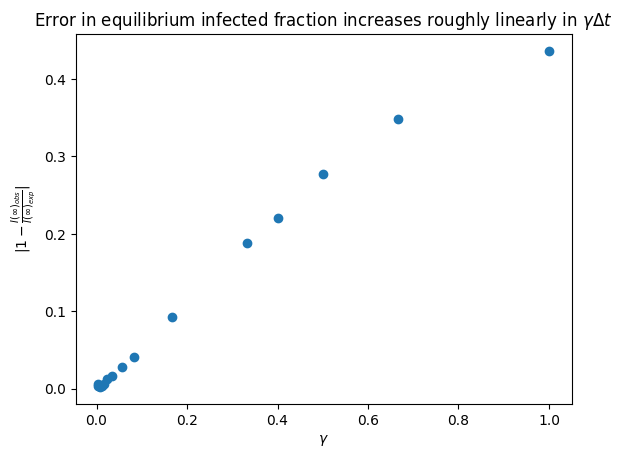

In [25]:
plt.plot(gammas, np.abs(1 - final_observed / final_expected), "o")
plt.xlabel(r"$\gamma$")
plt.ylabel("$| 1 - \\frac{I(\\infty)_{obs}}{I(\\infty)_{exp}} |$")
plt.title(r"Error in equilibrium infected fraction increases roughly linearly in $\gamma \Delta t$")